# Machine Learning

Key Concepts
------------

1. Overfitting
2. Evaluation Metric: Precision, Recall and F1
3. Iris Classification Using Petal and Sepal Features 
4. Hand-written Digits Recognition


1. Overfitting
---------------------

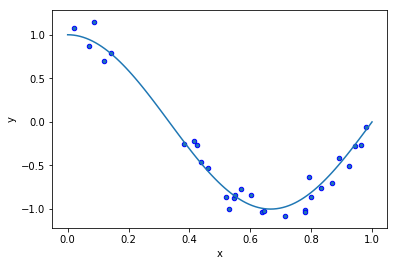

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, true_fun(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

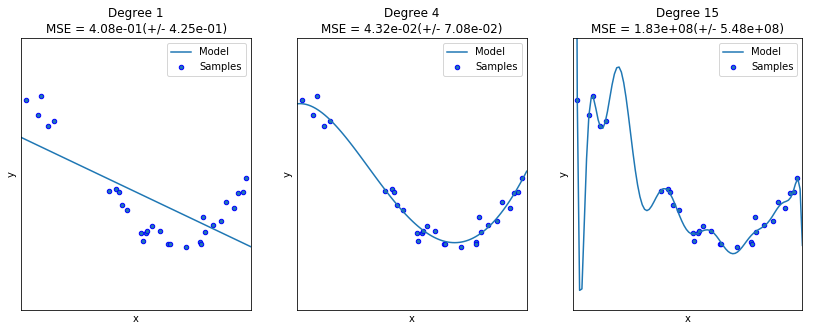

In [2]:

# Fit the samples with different degrees
degrees = [1, 4, 15]

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
#     plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()



Three Datasets
------------

* *Training Dataset* 
* **Validation Dataset*
* *Test Dataset*


2. The Evaluation Metric
------------


In [4]:
import pandas as pd

predict_dict = {'expected': [True, True, False, False], 
        'predict1': [True, True, True, False], 
        'predict2': [True, False, False, False]}
df = pd.DataFrame(predict_dict)
print (df)

   expected  predict1  predict2
0      True      True      True
1      True      True     False
2     False      True     False
3     False     False     False


In [5]:
# Calculate the accuracy for prediction1
# Accuracy = (# of Correct Predictions)/ (All Predictions)

# The accuracy for predict1
accuracy1 = np.sum(df['expected'] == df['predict1'])/len(df['predict1'])
print (accuracy1)

0.75


<div style="border: 3px solid green; padding: 10px">
<b>Exercise 1:</b> Calculate the accuracy for the model "predict2".
</div>

In [6]:
# The accuracy for predict2


<img src="../images/precision_recall.png",width=400,height=400,align="left">



$$Precision = \frac{true\_positives}{true\_positives + false\_positives}$$

$$Recall = \frac{true\_positives}{true\_positives + false\_negatives}$$


$$F1 = \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = \frac{2*Precision*Recall}{Precision+Recall}$$


In [7]:
# calculate the precision, recall, and F1 for predict1 and predict2

#for predict1
true_positive = np.sum(df[(df.expected == True) & (df.predict1 == True)].predict1)
print (true_positive)


2


<div style="border: 3px solid green; padding: 10px">
<b>Exercise 2:</b> Calculate the precision, recall and F1 for both models, "predict1" and "predict2".
</div>

In [8]:
#Calculate the precision, recall and F1 for both models, "predict1" and "predict2".


In [9]:
from sklearn import metrics

#use sklearn to calculate precision, recall, f1, and confusion matrix

#for predict1
print(metrics.classification_report(df.expected, df.predict1))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(df.expected, df.predict1))

#for predict2
print(metrics.classification_report(df.expected, df.predict2))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(df.expected, df.predict2))

             precision    recall  f1-score   support

      False       1.00      0.50      0.67         2
       True       0.67      1.00      0.80         2

avg / total       0.83      0.75      0.73         4

Confusion matrix:
[[1 1]
 [0 2]]
             precision    recall  f1-score   support

      False       0.67      1.00      0.80         2
       True       1.00      0.50      0.67         2

avg / total       0.83      0.75      0.73         4

Confusion matrix:
[[2 0]
 [1 1]]


Iris Classification Using Petal and Sepal Features 
------------

The classification task puts an *object* in some domain into one of a discrete set of *categories*, e.g. yes/no, friend/foe, good/bad/indifferent, blue/red/green, etc.


**The Goal**
Given a training set of labeled entities, develop a rule for assigning labels to entities in a test set. 

An Example of 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import pandas as pd

iris = datasets.load_iris()

df = pd.DataFrame(iris.data)
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df.columns = column_names
# Target classes
# 0: Iris Setosa 
# 1: Iris Versicolour 
# 2: Iris Virginica
df['isSetosa'] = (iris.target == 0)
print (df[:5])
print (df[-5:])

   sepal_length  sepal_width  petal_length  petal_width  isSetosa
0           5.1          3.5           1.4          0.2      True
1           4.9          3.0           1.4          0.2      True
2           4.7          3.2           1.3          0.2      True
3           4.6          3.1           1.5          0.2      True
4           5.0          3.6           1.4          0.2      True
     sepal_length  sepal_width  petal_length  petal_width  isSetosa
145           6.7          3.0           5.2          2.3     False
146           6.3          2.5           5.0          1.9     False
147           6.5          3.0           5.2          2.0     False
148           6.2          3.4           5.4          2.3     False
149           5.9          3.0           5.1          1.8     False


In [12]:
# To simplify the task, we uses two features: sepal length and sepal width 
# to predict whether an iris is a setosa? 

# Reformat the data
X = np.array(df[['sepal_length', 'sepal_width']])
Y = 1*np.array(df['isSetosa'])

In [13]:
from sklearn.cross_validation import train_test_split

# Split all the data into training data and testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print (len(x_train), x_train[0])
print (len(y_train), y_train[0])

print (len(x_test), x_test[0])
print (len(y_test), y_test[0])


105 [ 5.5  2.4]
105 0
45 [ 6.1  2.8]
45 0


/Users/chenzhe/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Logistic Regression
----------------



Logistic regression represents the probability
of category i using a linear function of the input variables:

$$P(Y=1 | X=(x_1, x_2)) = \frac{\exp(w_1 * x_1 + w_2 * x_2 + b)}{1+\exp(w_1 * x_1 + w_2 * x_2 + b)}$$

$$P(Y=0 | X=(x_1, x_2)) = \frac{1}{1+\exp(w_1 * x_1 + w_2 * x_2 + b)}$$

The logistic regression algorithms attempt to find the values for ($w_1, w_2, b$) in order to maximize the likelihood in the training data. 

In [14]:
# Train logistic regression using the sklean tool

logreg = linear_model.LogisticRegression()
logreg.fit(x_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

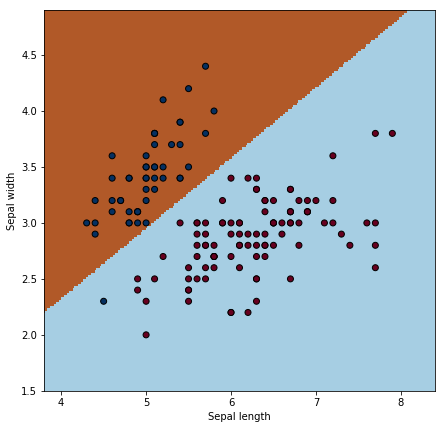

In [15]:


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])


# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(7, 7))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=np.reshape(Y, (len(Y))), edgecolors='k', cmap='RdBu')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

In [16]:
# Print the trained weights and intercept
print (logreg.coef_)
print (logreg.intercept_)

[[-2.19848683  3.49704579]]
[ 0.67817361]


In [17]:
# Evaluate the model on test data

predict = logreg.predict(x_test)

print(metrics.classification_report(y_test, predict))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predict))


             precision    recall  f1-score   support

          0       1.00      1.00      1.00        26
          1       1.00      1.00      1.00        19

avg / total       1.00      1.00      1.00        45

Confusion matrix:
[[26  0]
 [ 0 19]]


<div style="border: 3px solid green; padding: 10px">
<b>Exercise 3:</b> Try to use the features 'petal_length' and 'petal_width' to predict whether an iris flower is setosa, and try to check which features are better. 
</div>

Hand-written Digits Recognition
------------

In [18]:

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

print (len(digits.images))
print (len(digits.target))

images_and_labels = list(zip(digits.images, digits.target))
print (images_and_labels[0])

1797
1797
(array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.],
       [  0.,   0.,  13.,  15.,  10.,  15.,   5.,   0.],
       [  0.,   3.,  15.,   2.,   0.,  11.,   8.,   0.],
       [  0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.],
       [  0.,   5.,   8.,   0.,   0.,   9.,   8.,   0.],
       [  0.,   4.,  11.,   0.,   1.,  12.,   7.,   0.],
       [  0.,   2.,  14.,   5.,  10.,  12.,   0.,   0.],
       [  0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]]), 0)


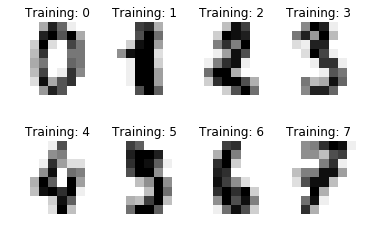

In [19]:
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.

for index, (image, label) in enumerate(images_and_labels[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('Training: %i' % label)
    
plt.show()

In [20]:
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
print (data[0])

[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.   5.
   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.   0.   8.
   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.  11.   0.   1.
  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.   0.   0.   6.  13.
  10.   0.   0.   0.]


In [21]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)



<img src="../images/svm.png",width=400,height=400>


In [22]:

# We learn the digits on the first half of the digits
classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])

# Now predict the value of the digit on the second half:
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))


Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       1.00      0.99      0.99        88
          1       0.99      0.97      0.98        91
          2       0.99      0.99      0.99        86
          3       0.98      0.87      0.92        91
          4       0.99      0.96      0.97        92
          5       0.95      0.97      0.96        91
          6       0.99      0.99      0.99        91
          7       0.96      0.99      0.97        89
          8       0.94      1.00      0.97        88
          9       0.93      0.98      0.95        92

avg / total       0.97      0.97      0.97       899


Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1 

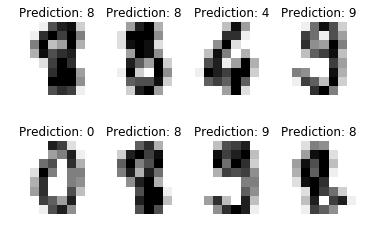

In [23]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('Prediction: %i' % prediction)

plt.show()


In [24]:
# Part of the code is borrowed from 
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause
